<a href="https://colab.research.google.com/github/toraaglobal/fashion-mnist/blob/master/03_model_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Mount the gdrive
import os
from google.colab import drive
drive.mount('/content/drive')


## change directry to the gdrive

os.chdir('./drive/My Drive/Colab Notebooks/lab3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import struct

%matplotlib inline

In [4]:
## load data
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

## load traning set
X_train, y_train = load_mnist('./data/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

## load test set
X_test, y_test = load_mnist('./data/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


## Random Forest

**Benefits of Tree-Based Models**
* Works for both classification and regression
* Handles categorical features naturally
* No assumption of distributions
* Can handle non-linear interactions
* No need for feature scaling / transformation
* Handles missing values in the variables

**Advantages:**

* Built in cross validation (OOB Scores)
* Built in Feature Selection (implicit)
* Feature importance
* Default hyper parameters are great and Works well "off the shelf"
* Minimum hyper parameter tuning
* RF natively detects interactions
* It's parametric (you don't have to make any assumptions of your data)

**Disadvantages:**

* RF is a black box (It's literally a function of 1000 decision trees)
* It doesn't tell you "how" the features are important

In [0]:
## packages
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

### Baseline model: Random Forest

In [6]:
# Create the baseline 
model_1 = RandomForestClassifier(oob_score=True, random_state=42)

# Fit and Evaluate OOB
model_1 = model_1.fit(X_train, y_train)

# Calculate OOB Score
print("The OOB Score is: " + str(model_1.oob_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The OOB Score is: 0.8125333333333333


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


### Cross Validation score

In [7]:
rf_result = cross_val_score(model_1, X_train, y_train, scoring='accuracy')

rf_result.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWa

0.85645

### Feature Scaling

Does Scaling Affect Performance? Is it neccessary for tree based models?

In [0]:
X_train_scaled = StandardScaler().fit(X_train).transform(X_train)

#### Fit Standardized Training Set

In [10]:
# Create the baseline 
model_2= RandomForestClassifier(oob_score=True, random_state=40)

# Fit and Evaluate OOB
model_2 = model_2.fit(X_train_scaled, y_train)

# Calculate OOB Score
model_2.oob_score_

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.8066

**Parameters that will make your model better**
* max_depth: The depth size of a tree
* n_estimators: The number of trees in the forest. Generally, the more trees the better accuracy, but slower computation.
* max_features: The max number of features that the algorithm can assign to an individual tree. Try ['auto', 'None', 'sqrt', 'log2', 0.9 and 0.2]
* min_samples_leaf: The minimum number of samples in newly created leaves. Try [1,2,3]. If 3 is best, try higher numbers.

**Parameters that will make your model faster**
* n_jobs: Determines the amount of multiple processors should be used to train/test the model. Always use -1 to use max cores and it'll run much faster
* random_state: Set this to a number (42) for reproducibility. It's used to replicate your results and for others as well.
* oob_score Random Forest's custom validation method: out-of-bag prediction

### Max Depth

The more depth (deeper the tree) means the higher chance of overfitting

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 depth
Accuracy Train:  0.9146333333333333
Accuracy Test:  0.7566
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2 depth
Accuracy Train:  0.9166
Accuracy Test:  0.7687
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3 depth
Accuracy Train:  0.9644833333333334
Accuracy Test:  0.8086
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4 depth
Accuracy Train:  0.97405
Accuracy Test:  0.8255
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 depth
Accuracy Train:  0.9843833333333334
Accuracy Test:  0.8357
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10 depth
Accuracy Train:  0.9955666666666667
Accuracy Test:  0.8563
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


20 depth
Accuracy Train:  0.9991
Accuracy Test:  0.8684
 
50 depth
Accuracy Train:  0.9999166666666667
Accuracy Test:  0.8758
 
100 depth
Accuracy Train:  1.0
Accuracy Test:  0.8774
 


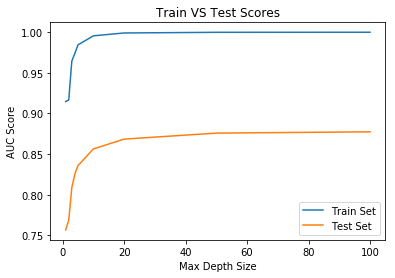

In [14]:
results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,10,20,50,100]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=44)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    roc1 = accuracy_score(y_train, pred)
    roc2 = accuracy_score(y_test, pred2)
    print('Accuracy Train: ', roc1)
    print('Accuracy Test: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

**n_estimators**

Generally the more trees the better. You'll generalize better with more trees and reduce the variance more. The only downside is computation time.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 trees
OOB:  0.34518333333333334
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2 trees
OOB:  0.49975
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3 trees
OOB:  0.6021666666666666
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4 trees
OOB:  0.6694
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 trees
OOB:  0.7156833333333333
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


15 trees
OOB:  0.83965
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


20 trees
OOB:  0.8508666666666667
 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


25 trees
OOB:  0.8592
 
40 trees
OOB:  0.8690833333333333
 
50 trees
OOB:  0.8730666666666667
 
70 trees
OOB:  0.8767666666666667
 
100 trees
OOB:  0.8805
 
200 trees
OOB:  0.8840666666666667
 
500 trees
OOB:  0.8864333333333333
 
1000 trees
OOB:  0.8873833333333333
 


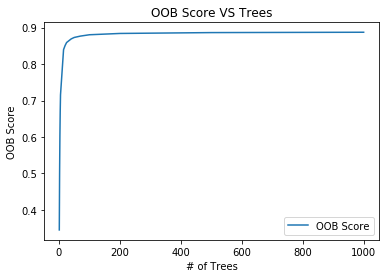

In [17]:
results = []
n_estimator_options = [1, 2, 3, 4, 5, 15, 20, 25, 40, 50, 70, 100,200,500,1000]

for trees in n_estimator_options:
    model = RandomForestClassifier(n_estimators =trees, oob_score=True, random_state=42, n_jobs =-1, max_depth=50)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(trees, 'trees')
    OOB = model.oob_score_
    print('OOB: ', OOB)
    results.append(OOB)
    print (" ")
    
plt.plot(n_estimator_options, results, label='OOB Score')
plt.xlabel('# of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")
plt.show()

**Max Features**

auto option
OOB:  0.8805
 
None option
OOB:  0.8737166666666667
 
sqrt option
OOB:  0.8805
 
log2 option
OOB:  0.8736
 
0.7 option
OOB:  0.8790833333333333
 
0.2 option
OOB:  0.8814
 


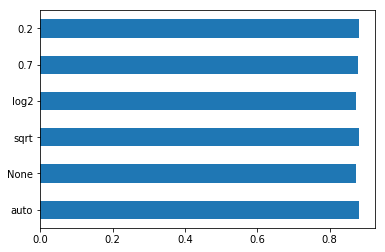

In [18]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.7, 0.2]

for max_features in max_features_options:
    model = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features, max_depth=50)
    model.fit(X_train, y_train)
    print(max_features, "option")
    oob = model.oob_score_
    print('OOB: ', oob)
    results.append(oob)
    print (" ")
    
pd.Series(results, max_features_options).plot(kind='barh')

### Min Sample Leafs

1 min samples
AUC:  0.8805
 
2 min samples
AUC:  0.8788666666666667
 
3 min samples
AUC:  0.8797833333333334
 
4 min samples
AUC:  0.8774666666666666
 
5 min samples
AUC:  0.8778
 
6 min samples
AUC:  0.87755
 
7 min samples
AUC:  0.8760833333333333
 
8 min samples
AUC:  0.8749666666666667
 
9 min samples
AUC:  0.8754833333333333
 
10 min samples
AUC:  0.87445
 
20 min samples
AUC:  0.8684
 


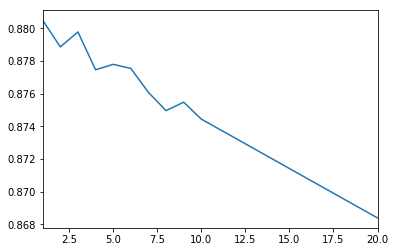

In [19]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,20]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=min_samples, max_depth=50)
    model.fit(X_train, y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    print (" ")
    
pd.Series(results, min_samples_leaf_options).plot()

### final model

In [21]:

## initialize the model
final_model= RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=1 , max_depth=50)

## fit the model
start = time.time()
final_model.fit(X_train, y_train)
end = time.time()
print("Training time: {}".format(end-start))

## make training prediction
t_prediction = final_model.predict(X_train)
score = accuracy_score(t_prediction, y_train)
print("Training accuracy: {}".format(score))

## make prediction
p_start = time.time()
prediction = final_model.predict(X_test)
p_end = time.time()
print("Prediction time: {}".format(p_end - p_start))
t_score = accuracy_score(prediction, y_test)
print("Test Accuracy: {}".format(t_score))



Training time: 84.05527687072754
Training accuracy: 0.9999833333333333
Prediction time: 0.5392892360687256
Test Accuracy: 0.876


## Interpretation

In [22]:
# The amount of trees used to ensemble
final_model.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                        max_features='auto', max_leaf_nodes=None,
                       

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0657355 to fit



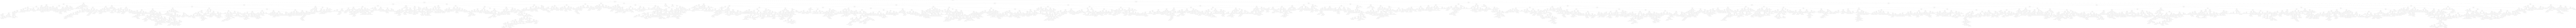

In [24]:
from IPython.display import Image 
from sklearn import tree
import pydotplus

## visualize single tree
#m = RandomForestClassifier(n_estimators=1, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=1, max_depth=50)
#m = m.fit(X_train, y_train)
# Create DOT data
dot_data = tree.export_graphviz(final_model.estimators_[0], out_file=None,  class_names=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0657355 to fit



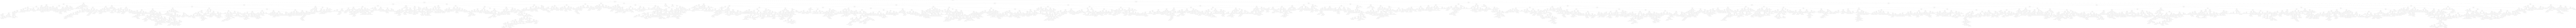

In [26]:
## visualize single tree
m = RandomForestClassifier(n_estimators=1, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=1, max_depth=50)
m = m.fit(X_train, y_train)
# Create DOT data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None,  class_names=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


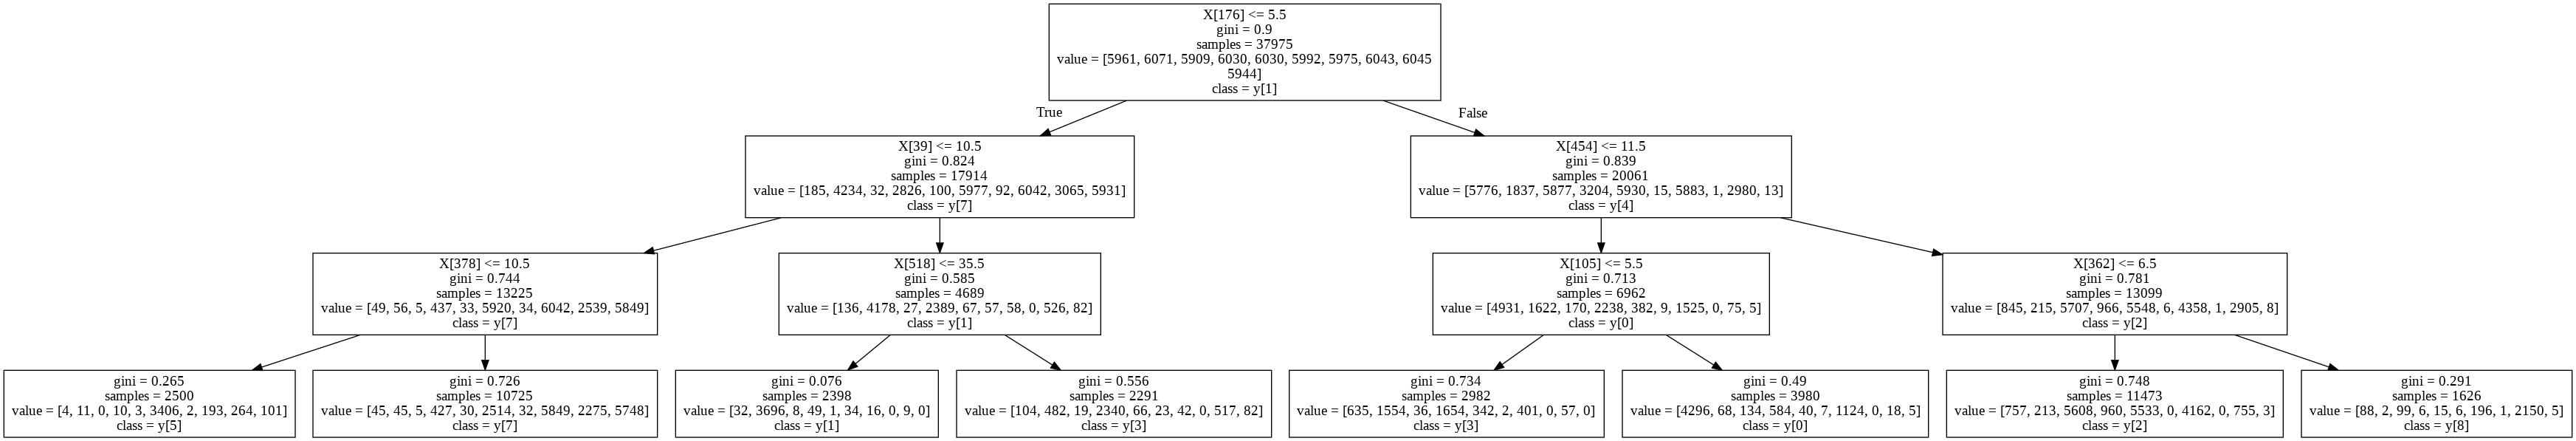

In [27]:
## visualize single tree
m = RandomForestClassifier(n_estimators=1, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=1, max_depth=3)
m = m.fit(X_train, y_train)
# Create DOT data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None,  class_names=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())